In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
from libs.models import dual_lstm
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(dual_lstm)

<module 'libs.models.dual_lstm' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models/dual_lstm.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,rsi_14,minus_di_15,eng_adx,eng_atr_div,adx_14,sma_100,vol_spike_14,macd_line_12_26_9,sma_20,bid,ask,signal
2004-01-02 13:09:00,0.00000,0.000000,0.000000,0.000279,0.625459,0.00000,0.528843,0.00000,0.00000,0.763664,0.764807,0.021536
2004-01-02 13:10:00,0.00000,0.000000,0.000000,0.000310,0.625379,0.00000,0.528775,0.00000,0.00000,0.763647,0.764790,0.023284
2004-01-02 13:11:00,0.00000,0.000000,0.000000,0.000341,0.625318,0.00000,0.528707,0.00000,0.00000,0.763631,0.764773,0.025175
2004-01-02 13:12:00,0.00000,0.000000,0.000000,0.000341,0.625263,0.00000,0.528641,0.00000,0.00000,0.763614,0.764757,0.027222
2004-01-02 13:13:00,0.00000,0.000000,0.000000,0.000341,0.625227,0.00000,0.528573,0.00000,0.00000,0.763597,0.764740,0.029436
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.67217,0.024691,0.023121,0.024910,0.635234,0.73661,0.541606,0.36312,0.66709,196.667400,196.962600,0.684908
2025-06-18 20:57:00,0.61669,0.024691,0.023121,0.025902,0.629672,0.58962,0.542649,0.34721,0.61512,196.527500,196.822500,0.612206
2025-06-18 20:58:00,0.61473,0.030864,0.023121,0.025499,0.628744,0.58091,0.545497,0.33627,0.61329,196.522500,196.817500,0.610468
2025-06-18 20:59:00,0.47540,0.030864,0.023121,0.031509,0.616953,0.17135,0.538547,0.29058,0.48143,196.092800,196.387200,0.477090


In [4]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_feat_sel.index
        .to_series()
        .groupby(df_feat_sel.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120]

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

# look_backs = [30, 45, 60, 75, 90] ################################

def objective(trial):
    
    hp = {
    # ── Architecture ────────────────────────────────────────────────
    "look_back"    : trial.suggest_categorical("look_back", look_backs),
    "DROPOUT_SHORT": trial.suggest_float("DROPOUT_SHORT", 0.05, 0.35),
    "DROPOUT_LONG":  trial.suggest_float("DROPOUT_LONG",  0.05, 0.35),
    "ATT_DROPOUT":   trial.suggest_float("ATT_DROPOUT",   0.05, 0.35),
    
    # ── Optimizer & Scheduler ──────────────────────────────────────
    "INITIAL_LR":    trial.suggest_float("INITIAL_LR",    1e-5, 1e-3,   log=True),
    "ETA_MIN":       trial.suggest_float("ETA_MIN",       1e-6, 1e-5,   log=True),
    "WEIGHT_DECAY":  trial.suggest_float("WEIGHT_DECAY",  1e-5, 1e-2,  log=True),
    "CLIPNORM":      trial.suggest_float("CLIPNORM",      0.1, 10),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    sess_start_pred = dt.time(*divmod((params.sess_start.hour * 60 + params.sess_start.minute) - hp["look_back"], 60))
    
    print('Build LSTM input tensors (disk-backed memmaps)...')
    X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models_core.build_tensors(
        df            = df_feat_sel,
        sess_start    = sess_start_pred 
    )
    
    print('Split into train/val/test by calendar day...')
    (
    (X_tr,  y_sig_tr,  y_ret_tr),
    (X_val, y_sig_val, y_ret_val),
    (X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
    samples_per_day,
    day_id_tr, day_id_val, day_id_te
    ) = models_core.chronological_split(
        X, y_sig, y_ret,
        raw_close, raw_bid, raw_ask,
        end_times   = end_times,
        train_prop  = params.train_prop,
        val_prop    = params.val_prop,
        train_batch = params.hparams['TRAIN_BATCH']
    )

    print('Carve `end_times` into the same three splits...')
    n_tr  = day_id_tr .shape[0] 
    n_val = day_id_val.shape[0]
    i_tr  = n_tr
    i_val = n_tr + n_val
    
    end_times_tr  = end_times[:i_tr]
    end_times_val = end_times[i_tr:i_val]
    end_times_te  = end_times[i_val:]
    
    print('Build DataLoaders over calendar‐days...')
    train_loader, val_loader, test_loader = models_core.split_to_day_datasets(
        # train split:   
        X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
        # val split:
        X_val,           y_sig_val,    y_ret_val,  end_times_val,
        # test split + raw‐prices
        X_te,            y_sig_te,     y_ret_te,   end_times_te,
        raw_close_te, raw_bid_te, raw_ask_te,
        
        sess_start_time       = sess_start_pred,
        signal_thresh         = params.best_optuna_params["buy_threshold"],
        return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
        train_batch           = params.hparams["TRAIN_BATCH"],
        train_workers         = params.hparams["NUM_WORKERS"],
        train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
    )

    print('Instantiate the stateful DualMemoryLSTM...')
    model = dual_lstm.DualMemoryLSTM(
        n_feats        = X.shape[-1],                          
        short_units    = params.hparams['SHORT_UNITS'],    
        long_units     = params.hparams['LONG_UNITS'],     
        dropout_short  = hp["DROPOUT_SHORT"],  
        dropout_long   = hp["DROPOUT_LONG"],   
        att_heads      = params.hparams['ATT_HEADS'],
        att_drop       = hp['ATT_DROPOUT']
    )
    model.to(params.device)  

    print('Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...')
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models_core.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )
    
    print('Run the custom stateful training loop...')
    best_val_rmse  = dual_lstm.lstm_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams['MAX_EPOCHS'],
        early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
        clipnorm            = hp["CLIPNORM"],
        device              = params.device
    )

    print('Delete variables to free memory...')
    del model, optimizer, plateau_sched, cosine_sched, scaler
    del X, y_sig, y_ret, raw_close, raw_bid, raw_ask
    del X_tr,  y_sig_tr,  y_ret_tr, X_val, y_sig_val, y_ret_val, X_te,  y_sig_te,  y_ret_te
    del raw_close_te, raw_bid_te, raw_ask_te
    del train_loader, val_loader, test_loader

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_val_rmse


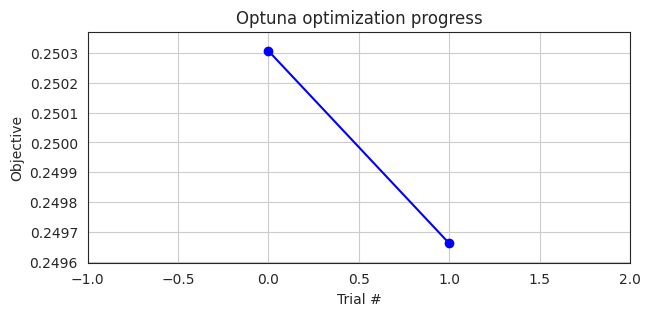

In [6]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-09-17 12:07:42,148] A new study created in RDB with name: no-name-6d07a592-472a-4409-ba0f-6752ebea96cf



▶ Trial 0 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.07958527397282814, 'DROPOUT_LONG': 0.19779471993318465, 'ATT_DROPOUT': 0.07401858275897479, 'INITIAL_LR': 0.00015099222423095652, 'ETA_MIN': 1.9955240846996957e-06, 'WEIGHT_DECAY': 0.0004540457240965803, 'CLIPNORM': 2.4546284037356485}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['rsi_14', 'minus_di_15', 'eng_adx', 'eng_atr_div', 'adx_14', 'sma_100', 'vol_spike_14', 'macd_line_12_26_9', 'sma_20']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


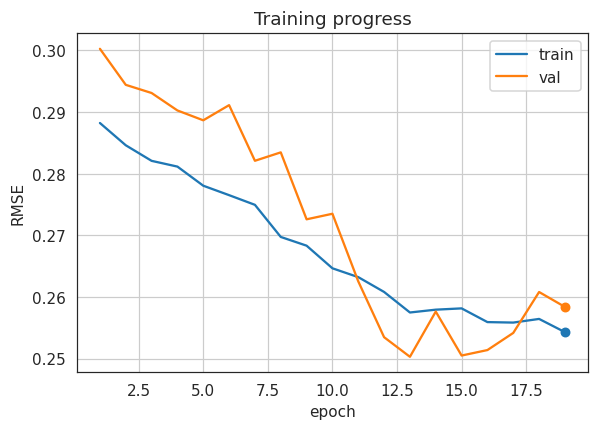

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2882 MAE=0.2229 R2=0.0093 | "B": Acc=0.2839 Prec=0.2748 Rec=0.9752 F1=0.4287 AUROC=0.4792
VALID→ "R": RMSE=0.3003 MAE=0.2049 R2=-0.0945 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.5804
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.30027_chp.pth


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2846 MAE=0.2245 R2=0.0340 | "B": Acc=0.2768 Prec=0.2756 Rec=0.9974 F1=0.4318 AUROC=0.4956
VALID→ "R": RMSE=0.2944 MAE=0.2013 R2=-0.0523 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6131
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.29443_chp.pth


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2821 MAE=0.2221 R2=0.0510 | "B": Acc=0.2762 Prec=0.2756 Rec=0.9989 F1=0.4320 AUROC=0.5165
VALID→ "R": RMSE=0.2931 MAE=0.1996 R2=-0.0429 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6267
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.29310_chp.pth


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2812 MAE=0.2206 R2=0.0573 | "B": Acc=0.2763 Prec=0.2756 Rec=0.9990 F1=0.4321 AUROC=0.5401
VALID→ "R": RMSE=0.2903 MAE=0.1980 R2=-0.0228 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6249
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.29027_chp.pth


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2781 MAE=0.2179 R2=0.0780 | "B": Acc=0.2775 Prec=0.2758 Rec=0.9976 F1=0.4321 AUROC=0.5398
VALID→ "R": RMSE=0.2887 MAE=0.1965 R2=-0.0116 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6345
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.28867_chp.pth


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2765 MAE=0.2170 R2=0.0881 | "B": Acc=0.2795 Prec=0.2759 Rec=0.9942 F1=0.4320 AUROC=0.5328
VALID→ "R": RMSE=0.2911 MAE=0.1957 R2=-0.0289 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6467


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2750 MAE=0.2135 R2=0.0984 | "B": Acc=0.2820 Prec=0.2761 Rec=0.9902 F1=0.4318 AUROC=0.5342
VALID→ "R": RMSE=0.2821 MAE=0.1928 R2=0.0339 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6503
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.28211_chp.pth


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2698 MAE=0.2083 R2=0.1323 | "B": Acc=0.2847 Prec=0.2767 Rec=0.9887 F1=0.4324 AUROC=0.5553
VALID→ "R": RMSE=0.2835 MAE=0.1910 R2=0.0245 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6687


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2683 MAE=0.2093 R2=0.1414 | "B": Acc=0.2864 Prec=0.2769 Rec=0.9863 F1=0.4324 AUROC=0.5607
VALID→ "R": RMSE=0.2726 MAE=0.1879 R2=0.0978 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6721
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.27261_chp.pth


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2647 MAE=0.2029 R2=0.1647 | "B": Acc=0.2906 Prec=0.2778 Rec=0.9839 F1=0.4332 AUROC=0.5703
VALID→ "R": RMSE=0.2735 MAE=0.1859 R2=0.0919 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6851


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2632 MAE=0.1996 R2=0.1737 | "B": Acc=0.2965 Prec=0.2788 Rec=0.9789 F1=0.4340 AUROC=0.5796
VALID→ "R": RMSE=0.2625 MAE=0.1833 R2=0.1632 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6914
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26254_chp.pth


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2608 MAE=0.2006 R2=0.1887 | "B": Acc=0.3034 Prec=0.2799 Rec=0.9715 F1=0.4346 AUROC=0.5788
VALID→ "R": RMSE=0.2535 MAE=0.1850 R2=0.2200 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6803
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25349_chp.pth


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2575 MAE=0.1977 R2=0.2093 | "B": Acc=0.3087 Prec=0.2799 Rec=0.9591 F1=0.4333 AUROC=0.5637
VALID→ "R": RMSE=0.2503 MAE=0.1911 R2=0.2394 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6673
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25031_chp.pth


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2580 MAE=0.1985 R2=0.2065 | "B": Acc=0.3237 Prec=0.2811 Rec=0.9334 F1=0.4320 AUROC=0.5533
VALID→ "R": RMSE=0.2576 MAE=0.1810 R2=0.1942 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6898


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2582 MAE=0.1991 R2=0.2052 | "B": Acc=0.3198 Prec=0.2803 Rec=0.9370 F1=0.4315 AUROC=0.5498
VALID→ "R": RMSE=0.2505 MAE=0.1848 R2=0.2382 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6812


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2559 MAE=0.1960 R2=0.2189 | "B": Acc=0.3427 Prec=0.2836 Rec=0.9078 F1=0.4322 AUROC=0.5564
VALID→ "R": RMSE=0.2514 MAE=0.1834 R2=0.2328 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6743


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2559 MAE=0.1948 R2=0.2193 | "B": Acc=0.3644 Prec=0.2858 Rec=0.8714 F1=0.4304 AUROC=0.5539
VALID→ "R": RMSE=0.2542 MAE=0.1808 R2=0.2157 | "B": Acc=0.2873 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6810


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2564 MAE=0.1966 R2=0.2157 | "B": Acc=0.3701 Prec=0.2856 Rec=0.8568 F1=0.4285 AUROC=0.5494
VALID→ "R": RMSE=0.2608 MAE=0.1798 R2=0.1742 | "B": Acc=0.2874 Prec=0.2873 Rec=1.0000 F1=0.4464 AUROC=0.6730


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2543 MAE=0.1937 R2=0.2288 | "B": Acc=0.3865 Prec=0.2859 Rec=0.8191 F1=0.4239 AUROC=0.5391
VALID→ "R": RMSE=0.2584 MAE=0.1798 R2=0.1895 | "B": Acc=0.2875 Prec=0.2874 Rec=1.0000 F1=0.4464 AUROC=0.6555
Early stopping at epoch 19
✅ Final best model (_fin) saved: AAPL_0.25031_fin.pth
Delete variables to free memory...


[I 2025-09-17 12:25:12,942] Trial 0 finished with value: 0.25030624866485596 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.07958527397282814, 'DROPOUT_LONG': 0.19779471993318465, 'ATT_DROPOUT': 0.07401858275897479, 'INITIAL_LR': 0.00015099222423095652, 'ETA_MIN': 1.9955240846996957e-06, 'WEIGHT_DECAY': 0.0004540457240965803, 'CLIPNORM': 2.4546284037356485}. Best is trial 0 with value: 0.25030624866485596.



▶ Trial 1 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.07700009456215443, 'DROPOUT_LONG': 0.30246123604964786, 'ATT_DROPOUT': 0.2015086303834806, 'INITIAL_LR': 0.0002718174721671645, 'ETA_MIN': 1.6706829720983285e-06, 'WEIGHT_DECAY': 0.0034201355008973717, 'CLIPNORM': 9.461547240569047}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['rsi_14', 'minus_di_15', 'eng_adx', 'eng_atr_div', 'adx_14', 'sma_100', 'vol_spike_14', 'macd_line_12_26_9', 'sma_20']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


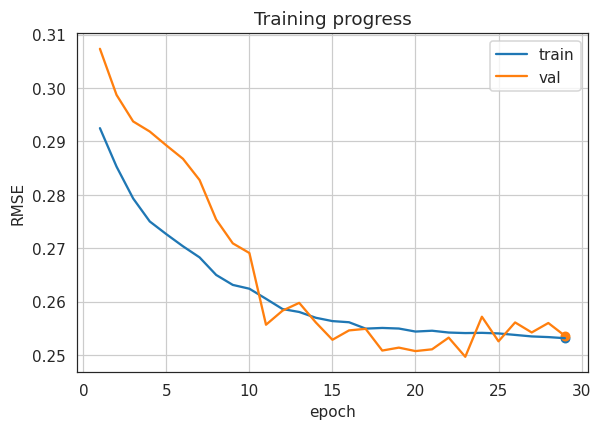

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2925 MAE=0.2288 R2=-0.0201 | "B": Acc=0.6830 Prec=0.3136 Rec=0.1267 F1=0.1805 AUROC=0.5319
VALID→ "R": RMSE=0.3073 MAE=0.2061 R2=-0.1466 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6824


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2853 MAE=0.2250 R2=0.0295 | "B": Acc=0.6985 Prec=0.3407 Rec=0.1008 F1=0.1556 AUROC=0.5507
VALID→ "R": RMSE=0.2987 MAE=0.2003 R2=-0.0831 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6813


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2793 MAE=0.2189 R2=0.0696 | "B": Acc=0.7109 Prec=0.3865 Rec=0.0839 F1=0.1379 AUROC=0.5784
VALID→ "R": RMSE=0.2937 MAE=0.1966 R2=-0.0474 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6829


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2750 MAE=0.2139 R2=0.0981 | "B": Acc=0.7201 Prec=0.4396 Rec=0.0571 F1=0.1011 AUROC=0.5934
VALID→ "R": RMSE=0.2918 MAE=0.1951 R2=-0.0339 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6868


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2726 MAE=0.2114 R2=0.1137 | "B": Acc=0.7237 Prec=0.4794 Rec=0.0338 F1=0.0631 AUROC=0.5953
VALID→ "R": RMSE=0.2892 MAE=0.1935 R2=-0.0156 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6886


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2704 MAE=0.2089 R2=0.1284 | "B": Acc=0.7250 Prec=0.5208 Rec=0.0245 F1=0.0468 AUROC=0.5994
VALID→ "R": RMSE=0.2867 MAE=0.1919 R2=0.0019 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6875


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2683 MAE=0.2074 R2=0.1417 | "B": Acc=0.7256 Prec=0.5608 Rec=0.0198 F1=0.0383 AUROC=0.6005
VALID→ "R": RMSE=0.2828 MAE=0.1898 R2=0.0294 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6866


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2650 MAE=0.2025 R2=0.1626 | "B": Acc=0.7259 Prec=0.5875 Rec=0.0171 F1=0.0331 AUROC=0.5991
VALID→ "R": RMSE=0.2754 MAE=0.1868 R2=0.0796 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6949


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2631 MAE=0.2012 R2=0.1744 | "B": Acc=0.7260 Prec=0.6016 Rec=0.0171 F1=0.0333 AUROC=0.6006
VALID→ "R": RMSE=0.2709 MAE=0.1849 R2=0.1091 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6996


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2624 MAE=0.2027 R2=0.1789 | "B": Acc=0.7262 Prec=0.6000 Rec=0.0190 F1=0.0367 AUROC=0.6005
VALID→ "R": RMSE=0.2691 MAE=0.1836 R2=0.1210 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.7077


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2605 MAE=0.2016 R2=0.1906 | "B": Acc=0.7268 Prec=0.6090 Rec=0.0237 F1=0.0457 AUROC=0.6104
VALID→ "R": RMSE=0.2557 MAE=0.1861 R2=0.2065 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.7241


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2586 MAE=0.2001 R2=0.2025 | "B": Acc=0.7267 Prec=0.5933 Rec=0.0264 F1=0.0506 AUROC=0.6119
VALID→ "R": RMSE=0.2583 MAE=0.1818 R2=0.1900 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.7219


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2581 MAE=0.1989 R2=0.2059 | "B": Acc=0.7268 Prec=0.5979 Rec=0.0255 F1=0.0490 AUROC=0.6098
VALID→ "R": RMSE=0.2598 MAE=0.1811 R2=0.1809 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.7229


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2570 MAE=0.1977 R2=0.2125 | "B": Acc=0.7270 Prec=0.6004 Rec=0.0280 F1=0.0535 AUROC=0.6124
VALID→ "R": RMSE=0.2561 MAE=0.1819 R2=0.2039 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.7256


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2563 MAE=0.1960 R2=0.2164 | "B": Acc=0.7272 Prec=0.5999 Rec=0.0305 F1=0.0580 AUROC=0.6110
VALID→ "R": RMSE=0.2528 MAE=0.1852 R2=0.2239 | "B": Acc=0.7128 Prec=0.8750 Rec=0.0005 F1=0.0010 AUROC=0.7306


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2561 MAE=0.1970 R2=0.2177 | "B": Acc=0.7276 Prec=0.6032 Rec=0.0330 F1=0.0625 AUROC=0.6130
VALID→ "R": RMSE=0.2546 MAE=0.1821 R2=0.2131 | "B": Acc=0.7129 Prec=0.8608 Rec=0.0007 F1=0.0014 AUROC=0.7281


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2549 MAE=0.1947 R2=0.2249 | "B": Acc=0.7276 Prec=0.6010 Rec=0.0343 F1=0.0649 AUROC=0.6140
VALID→ "R": RMSE=0.2549 MAE=0.1810 R2=0.2113 | "B": Acc=0.7129 Prec=0.8713 Rec=0.0009 F1=0.0018 AUROC=0.7280


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2551 MAE=0.1943 R2=0.2242 | "B": Acc=0.7278 Prec=0.6010 Rec=0.0361 F1=0.0681 AUROC=0.6122
VALID→ "R": RMSE=0.2508 MAE=0.1849 R2=0.2362 | "B": Acc=0.7132 Prec=0.8656 Rec=0.0023 F1=0.0045 AUROC=0.7355


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2550 MAE=0.1948 R2=0.2248 | "B": Acc=0.7278 Prec=0.6044 Rec=0.0355 F1=0.0670 AUROC=0.6090
VALID→ "R": RMSE=0.2514 MAE=0.1833 R2=0.2329 | "B": Acc=0.7129 Prec=0.8632 Rec=0.0008 F1=0.0017 AUROC=0.7341


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2544 MAE=0.1943 R2=0.2283 | "B": Acc=0.7283 Prec=0.6132 Rec=0.0378 F1=0.0712 AUROC=0.6140
VALID→ "R": RMSE=0.2507 MAE=0.1839 R2=0.2368 | "B": Acc=0.7132 Prec=0.8522 Rec=0.0020 F1=0.0040 AUROC=0.7359


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2545 MAE=0.1945 R2=0.2273 | "B": Acc=0.7285 Prec=0.6201 Rec=0.0381 F1=0.0718 AUROC=0.6127
VALID→ "R": RMSE=0.2511 MAE=0.1827 R2=0.2348 | "B": Acc=0.7134 Prec=0.8815 Rec=0.0030 F1=0.0059 AUROC=0.7329


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2542 MAE=0.1933 R2=0.2294 | "B": Acc=0.7286 Prec=0.6411 Rec=0.0345 F1=0.0654 AUROC=0.6105
VALID→ "R": RMSE=0.2533 MAE=0.1808 R2=0.2214 | "B": Acc=0.7129 Prec=0.8320 Rec=0.0011 F1=0.0021 AUROC=0.7259


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2541 MAE=0.1935 R2=0.2300 | "B": Acc=0.7287 Prec=0.6392 Rec=0.0355 F1=0.0672 AUROC=0.6114
VALID→ "R": RMSE=0.2497 MAE=0.1847 R2=0.2433 | "B": Acc=0.7130 Prec=0.8424 Rec=0.0014 F1=0.0029 AUROC=0.7332
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24966_chp.pth


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2541 MAE=0.1951 R2=0.2297 | "B": Acc=0.7291 Prec=0.6355 Rec=0.0396 F1=0.0746 AUROC=0.6126
VALID→ "R": RMSE=0.2572 MAE=0.1794 R2=0.1972 | "B": Acc=0.7135 Prec=0.8787 Rec=0.0031 F1=0.0061 AUROC=0.7170


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2540 MAE=0.1946 R2=0.2304 | "B": Acc=0.7296 Prec=0.6471 Rec=0.0413 F1=0.0776 AUROC=0.6139
VALID→ "R": RMSE=0.2526 MAE=0.1805 R2=0.2256 | "B": Acc=0.7131 Prec=0.8763 Rec=0.0017 F1=0.0033 AUROC=0.7204


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2538 MAE=0.1947 R2=0.2321 | "B": Acc=0.7294 Prec=0.6375 Rec=0.0416 F1=0.0782 AUROC=0.6145
VALID→ "R": RMSE=0.2561 MAE=0.1793 R2=0.2038 | "B": Acc=0.7138 Prec=0.8822 Rec=0.0042 F1=0.0084 AUROC=0.7176


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2535 MAE=0.1942 R2=0.2338 | "B": Acc=0.7297 Prec=0.6660 Rec=0.0379 F1=0.0717 AUROC=0.6133
VALID→ "R": RMSE=0.2542 MAE=0.1796 R2=0.2155 | "B": Acc=0.7138 Prec=0.8905 Rec=0.0045 F1=0.0090 AUROC=0.7165


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2534 MAE=0.1943 R2=0.2346 | "B": Acc=0.7307 Prec=0.6635 Rec=0.0461 F1=0.0862 AUROC=0.6150
VALID→ "R": RMSE=0.2560 MAE=0.1792 R2=0.2045 | "B": Acc=0.7150 Prec=0.9028 Rec=0.0090 F1=0.0178 AUROC=0.7136


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2531 MAE=0.1941 R2=0.2358 | "B": Acc=0.7315 Prec=0.6518 Rec=0.0552 F1=0.1017 AUROC=0.6190
VALID→ "R": RMSE=0.2536 MAE=0.1796 R2=0.2193 | "B": Acc=0.7167 Prec=0.9031 Rec=0.0155 F1=0.0305 AUROC=0.7198
Early stopping at epoch 29
✅ Final best model (_fin) saved: AAPL_0.24966_fin.pth
Delete variables to free memory...


[I 2025-09-17 12:50:39,296] Trial 1 finished with value: 0.24966204166412354 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.07700009456215443, 'DROPOUT_LONG': 0.30246123604964786, 'ATT_DROPOUT': 0.2015086303834806, 'INITIAL_LR': 0.0002718174721671645, 'ETA_MIN': 1.6706829720983285e-06, 'WEIGHT_DECAY': 0.0034201355008973717, 'CLIPNORM': 9.461547240569047}. Best is trial 1 with value: 0.24966204166412354.



▶ Trial 2 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.3422906468038359, 'DROPOUT_LONG': 0.32958988536566536, 'ATT_DROPOUT': 0.07203196318724112, 'INITIAL_LR': 0.00016470426735111453, 'ETA_MIN': 1.265386143733995e-06, 'WEIGHT_DECAY': 0.0027811867644050195, 'CLIPNORM': 7.108102429294761}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['rsi_14', 'minus_di_15', 'eng_adx', 'eng_atr_div', 'adx_14', 'sma_100', 'vol_spike_14', 'macd_line_12_26_9', 'sma_20']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


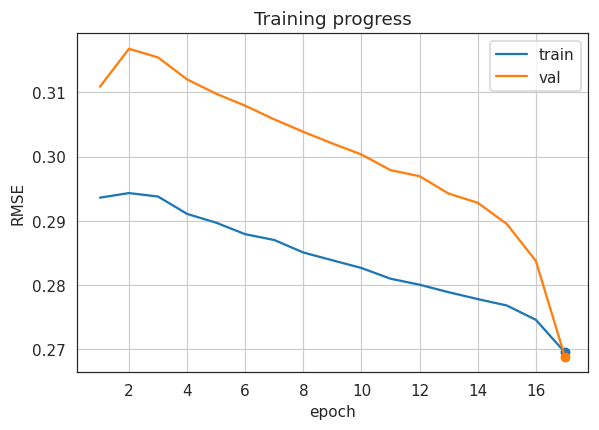

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2936 MAE=0.2303 R2=-0.0303 | "B": Acc=0.4066 Prec=0.2692 Rec=0.7017 F1=0.3891 AUROC=0.5006
VALID→ "R": RMSE=0.3109 MAE=0.2037 R2=-0.2053 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.6458


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2943 MAE=0.2353 R2=-0.0354 | "B": Acc=0.3769 Prec=0.2691 Rec=0.7656 F1=0.3983 AUROC=0.4995
VALID→ "R": RMSE=0.3168 MAE=0.2054 R2=-0.2514 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.6664


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2938 MAE=0.2329 R2=-0.0315 | "B": Acc=0.3501 Prec=0.2707 Rec=0.8337 F1=0.4087 AUROC=0.5039
VALID→ "R": RMSE=0.3155 MAE=0.2047 R2=-0.2408 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.6637


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2911 MAE=0.2256 R2=-0.0126 | "B": Acc=0.3498 Prec=0.2708 Rec=0.8350 F1=0.4089 AUROC=0.5058
VALID→ "R": RMSE=0.3120 MAE=0.2029 R2=-0.2141 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.6717


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2897 MAE=0.2261 R2=-0.0031 | "B": Acc=0.3462 Prec=0.2715 Rec=0.8479 F1=0.4113 AUROC=0.5085
VALID→ "R": RMSE=0.3098 MAE=0.2014 R2=-0.1967 | "B": Acc=0.2735 Prec=0.2735 Rec=1.0000 F1=0.4295 AUROC=0.6700


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2879 MAE=0.2248 R2=0.0092 | "B": Acc=0.3431 Prec=0.2729 Rec=0.8648 F1=0.4149 AUROC=0.5158
VALID→ "R": RMSE=0.3079 MAE=0.1999 R2=-0.1824 | "B": Acc=0.2743 Prec=0.2737 Rec=1.0000 F1=0.4298 AUROC=0.6741


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2870 MAE=0.2250 R2=0.0155 | "B": Acc=0.3597 Prec=0.2730 Rec=0.8282 F1=0.4107 AUROC=0.5137
VALID→ "R": RMSE=0.3058 MAE=0.1986 R2=-0.1661 | "B": Acc=0.2746 Prec=0.2738 Rec=1.0000 F1=0.4298 AUROC=0.6751


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2851 MAE=0.2228 R2=0.0288 | "B": Acc=0.3527 Prec=0.2757 Rec=0.8625 F1=0.4178 AUROC=0.5270
VALID→ "R": RMSE=0.3039 MAE=0.1975 R2=-0.1514 | "B": Acc=0.2835 Prec=0.2757 Rec=0.9959 F1=0.4319 AUROC=0.6778


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2839 MAE=0.2216 R2=0.0370 | "B": Acc=0.3777 Prec=0.2762 Rec=0.8085 F1=0.4117 AUROC=0.5234
VALID→ "R": RMSE=0.3021 MAE=0.1965 R2=-0.1376 | "B": Acc=0.2893 Prec=0.2771 Rec=0.9937 F1=0.4334 AUROC=0.6806


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2827 MAE=0.2206 R2=0.0451 | "B": Acc=0.3609 Prec=0.2771 Rec=0.8530 F1=0.4183 AUROC=0.5310
VALID→ "R": RMSE=0.3003 MAE=0.1956 R2=-0.1247 | "B": Acc=0.2941 Prec=0.2782 Rec=0.9919 F1=0.4345 AUROC=0.6829


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2810 MAE=0.2180 R2=0.0563 | "B": Acc=0.3849 Prec=0.2773 Rec=0.7996 F1=0.4118 AUROC=0.5267
VALID→ "R": RMSE=0.2979 MAE=0.1944 R2=-0.1066 | "B": Acc=0.3002 Prec=0.2796 Rec=0.9889 F1=0.4359 AUROC=0.6858


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2801 MAE=0.2182 R2=0.0626 | "B": Acc=0.3734 Prec=0.2783 Rec=0.8328 F1=0.4172 AUROC=0.5343
VALID→ "R": RMSE=0.2970 MAE=0.1937 R2=-0.0996 | "B": Acc=0.2936 Prec=0.2781 Rec=0.9924 F1=0.4345 AUROC=0.6877


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2789 MAE=0.2166 R2=0.0704 | "B": Acc=0.3898 Prec=0.2785 Rec=0.7957 F1=0.4126 AUROC=0.5316
VALID→ "R": RMSE=0.2942 MAE=0.1924 R2=-0.0796 | "B": Acc=0.3081 Prec=0.2815 Rec=0.9853 F1=0.4378 AUROC=0.6895


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2778 MAE=0.2166 R2=0.0776 | "B": Acc=0.3853 Prec=0.2787 Rec=0.8074 F1=0.4144 AUROC=0.5321
VALID→ "R": RMSE=0.2928 MAE=0.1914 R2=-0.0692 | "B": Acc=0.2856 Prec=0.2763 Rec=0.9960 F1=0.4326 AUROC=0.6907


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2768 MAE=0.2159 R2=0.0842 | "B": Acc=0.3943 Prec=0.2781 Rec=0.7823 F1=0.4103 AUROC=0.5281
VALID→ "R": RMSE=0.2895 MAE=0.1898 R2=-0.0452 | "B": Acc=0.3010 Prec=0.2799 Rec=0.9897 F1=0.4364 AUROC=0.6932


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2746 MAE=0.2143 R2=0.0989 | "B": Acc=0.3957 Prec=0.2802 Rec=0.7927 F1=0.4141 AUROC=0.5353
VALID→ "R": RMSE=0.2838 MAE=0.1872 R2=-0.0040 | "B": Acc=0.2841 Prec=0.2760 Rec=0.9968 F1=0.4323 AUROC=0.6980


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2695 MAE=0.2088 R2=0.1319 | "B": Acc=0.4064 Prec=0.2791 Rec=0.7606 F1=0.4084 AUROC=0.5295
VALID→ "R": RMSE=0.2688 MAE=0.1835 R2=0.0988 | "B": Acc=0.2846 Prec=0.2761 Rec=0.9968 F1=0.4325 AUROC=0.6995


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

[W 2025-09-17 13:07:27,068] Trial 2 failed with parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.3422906468038359, 'DROPOUT_LONG': 0.32958988536566536, 'ATT_DROPOUT': 0.07203196318724112, 'INITIAL_LR': 0.00016470426735111453, 'ETA_MIN': 1.265386143733995e-06, 'WEIGHT_DECAY': 0.0027811867644050195, 'CLIPNORM': 7.108102429294761} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_163/2195990082.py", line 105, in objective
    best_val_rmse  = dual_lstm.lstm_training_loop(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspace/my_models/Trading/_Stock_Analysis_/libs/models/dual_lstm.py", line 332, in lstm_training_loop
    train_rec .update(probs, cls_seq)
  File "/usr/local/lib/python3.12/dist-packages/torchmetrics/metric.py", line 549, in wrapped_

KeyboardInterrupt: 

In [7]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

        
study.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, plots.cleanup_callback],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
